In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy import sparse
%matplotlib inline

# Get Data

In [5]:
X = []
y = []
trdata = pd.read_csv('mnist_train.csv', sep=',', engine='python')
tstdata = pd.read_csv('mnist_test.csv', sep=',', engine='python')

X = trdata.as_matrix()
X = X.astype(np.float)
y = X[:,0]
X = X[:,1:]
print(X.shape, y.shape)

Xt = tstdata.as_matrix()
Xt = Xt.astype(np.float)
yt = Xt[:,0]
Xt = Xt[:,1:]
print(Xt.shape, yt.shape)

(59999, 784) (59999,)
(9999, 784) (9999,)


# Convert data to logistic data only

In [7]:
mask = (y == 0) | (y == 1)

X = X[mask]
y = y[mask]

mask = (yt == 0) | (yt == 1)
Xt = Xt[mask]
yt = yt[mask]

print(X.shape, y.shape)
print(Xt.shape, yt.shape)

(12665, 784) (12665,)
(2115, 784) (2115,)


# Normalize X

In [54]:
rownorms = np.linalg.norm(X,axis=1)
X = X / rownorms[:, np.newaxis]

rownorms = np.linalg.norm(Xt,axis=1)
Xt = Xt / rownorms[:, np.newaxis]

# Math

In [22]:
def sigmoid(x):
    return 1. / (1 + np.exp(x))

def RMSE(weights):
    diff = sigmoid(X @ weights) - y
    return 1. / X.shape[0] * (diff.T @ diff)**.5

# true positives over total positives
def precision(weights):
    prediction = np.round(sigmoid(Xt @ weights))
    total = 0
    for i in range(yt.shape[0]):
        total += int(prediction[i] == yt[i] == 1)
    return total / sum(yt)

# true positives over total predicted positives
def recall(weights):
    prediction = np.round(sigmoid(Xt @ weights))
    total = 0
    for i in range(yt.shape[0]):
        total += int(prediction[i] == yt[i] == 1)
    return total / sum(prediction)

# f1 = 2pr / (p + r)
def f1(weights):
    p = precision(weights)
    r = recall(weights)
    return 2 * p * r / (p + r)

# correct predictions / total guesses
def accuracy(weights):
    prediction = np.round(sigmoid(Xt @ weights))
    total = 0
    for i in range(yt.shape[0]):
        total += int(prediction[i] == yt[i])
    return total / yt.shape[0]

# Gradient

In [40]:
def gradient(weights, reg):
    return X.T @ (sigmoid(X @ weights) - y) + reg * weights

def gdescent(its, reg, lrnrate, printfreq = 10000):
    weights = np.random.randn(X.shape[1])
    for i in range(its):
        weights += lrnrate * gradient(weights, reg)
        if i + 1 % printfreq == 0:
            print(RMSE(weights))
    return weights

# Newton's Method

In [39]:
def newtstep(weights, reg):
    mu = sigmoid(X @ weights)
    mudiag = X.T @ sparse.diags(mu * (1 - mu)) @ X + sparse.eye(X.shape[1])
    return np.linalg.solve(mudiag, gradient(weights, reg))

def newtdescent(its, reg, printfreq = 10000):
    weights = np.random.randn(X.shape[1])
    for i in range(its):
        weights += newtstep(weights, reg)
        if i + 1 % printfreq == 0:
            print(RMSE(weights))
    return weights

# Plot Precision, Recall, F1, Accuracy

In [55]:
regs = np.linspace(0,20,50)

# grad descent and newton method iterations
gits = 100
nits = 10

p = []
r = []
f = []
a = []

for reg in regs:
    w1 = gdescent(gits, reg, 1)
    w2 = newtdescent(nits, reg)
    p += [[precision(w1), precision(w2)]]
    r += [[recall(w1), recall(w2)]]
    f += [[f1(w1), f1(w2)]]
    a += [[accuracy(w1), accuracy(w2)]]
    
p = np.array(p)
r = np.array(r)
f = np.array(f)
a = np.array(a)

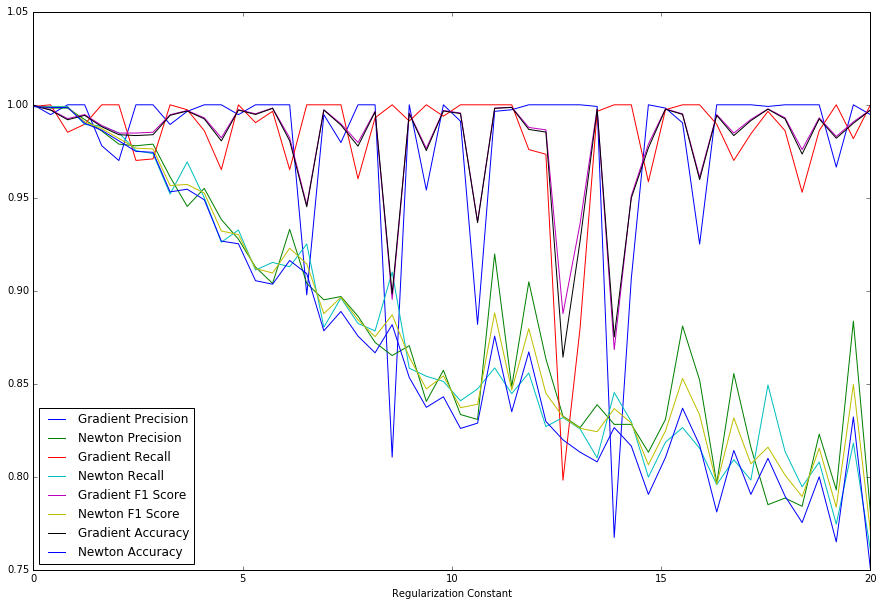

In [59]:
plt.figure(figsize = (15,10))

plt.plot(regs, p[:,0], label = 'Gradient Precision')
plt.plot(regs, p[:,1], label = 'Newton Precision')

plt.plot(regs, r[:,0], label = 'Gradient Recall')
plt.plot(regs, r[:,1], label = 'Newton Recall')

plt.plot(regs, f[:,0], label = 'Gradient F1 Score')
plt.plot(regs, f[:,1], label = 'Newton F1 Score')

plt.plot(regs, a[:,0], label = 'Gradient Accuracy')
plt.plot(regs, a[:,1], label = 'Newton Accuracy')

plt.xlabel('Regularization Constant')
plt.legend(loc = 'best')

In [60]:
gradient_best_index = np.argmax(a[:,0])
newton_best_index = np.argmax(a[:,1])


print(regs[gradient_best_index], a[gradient_best_index,0])
print(regs[newton_best_index], a[newton_best_index,0])

0.0 0.999527186761
0.0 0.999527186761
